In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import datetime
import copy
#import scipy.stats
#from scipy import signal
from functools import partial
import glob
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.units as munits
from matplotlib.dates import ConciseDateConverter
munits.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()
munits.registry[cftime.datetime] = ConciseDateConverter()
#from geocat.viz import util as gvutil
#import util
import cartopy
import xesmf as xe
#import xskillscore as xs
#cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
%matplotlib inline

#from HRDPutils import calendar_utils as cal
#from HRDPutils import stat_utils as stat
#from HRDPutils import mapplot_utils as maps
#from HRDPutils import colorbar_utils as cbars
#from HRDPutils import io_utils as io
#from HRDPutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Create Dask Cluster

In [3]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
#cluster.close()
#client.close()

In [4]:
# Use this if computing annual means:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=50GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(jobs=36) 

In [5]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/fredc/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.14:37880,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/fredc/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Main Processing

In [6]:
%%time
# get POP grid
infile='/glade/work/fredc/metric/grid/POP_tx0.1v3_grid.nc'
dsg = xr.open_dataset(infile)
tlon = dsg.TLONG.persist()
tlat = dsg.TLAT.persist()
tarea = dsg.TAREA.persist()
dzt = dsg.DZT.persist()
dzu = dsg.DZU.persist()
dxt = dsg.DXT.persist()
dyt = dsg.DYT.persist()
dxu = dsg.DXU.persist()
dyu = dsg.DYU.persist()
htn = dsg.HTN.persist()
hte = dsg.HTE.persist()
ht = dsg.HT.persist()
hu = dsg.HU.persist()

CPU times: user 23 ms, sys: 7.99 ms, total: 31 ms
Wall time: 116 ms


In [7]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/'
fin = datadir+'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.*.nc'

ds = xr.open_mfdataset(fin,
                       #parallel=True, # use dask to read in parallel
                       combine="nested",  # combine files in order provided
                       concat_dim="time",  # concatentate files along time dimension
                       data_vars="minimal",  # only concatentate data variables with "time" dimension
                       coords="minimal",  # same as above for coordinate variables
                       compat="override",
                       #preprocess=preprocess, # run this function on each dataset first before combining
                       #chunks={"nlat": "auto", "nlon": "auto"}, # choose simple
                       chunks={"time": 1}, # choose simple
                      )
ds['time'] = ds.time - datetime.timedelta(0.5) #middle of the month
mytime = ds['time']

In [8]:
%%time
ssh = ds.SSH.where(ds.SSH!=-1)
#ssh = ssh * 10. #in mm
ssh['TLONG'] = tlon
ssh['TLAT'] = tlat
ssh = ssh.isel(nlon=slice(120,285), nlat=slice(1365,1510))

CPU times: user 8.01 ms, sys: 9 µs, total: 8.02 ms
Wall time: 8.22 ms


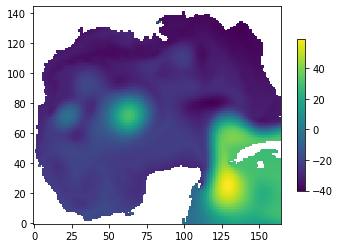

In [9]:
plt.figure()
plt.imshow(ssh.isel(time=0), interpolation='nearest', origin='lower')
plt.colorbar(shrink=0.7)

In [10]:
month_length = ds.time.dt.days_in_month
wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

In [11]:
yssh_rcp85_1 = (ssh * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(ssh) * wgts).resample(time="AS").sum(dim="time")
yssh_rcp85_1 = yssh_rcp85_1.where(yssh_rcp85_1!=0)

In [13]:
mask = xr.where(np.isnan(yssh_rcp85_1.isel(time=0)),0,1).load()
tearea = tarea.isel(nlon=slice(120,285), nlat=slice(1365,1510))
GoM_ssh_rcp85_1 = (yssh_rcp85_1 * tearea).sum(dim=['nlon','nlat']) / (mask * tearea).sum(dim=['nlon','nlat']) 
GoM_ssh_rcp85_1 = GoM_ssh_rcp85_1.load()

In [14]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002/ocn/proc/tseries/month_1/'
fin = datadir+'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.30.002.pop.h.SSH.*.nc'

ds2 = xr.open_mfdataset(fin,
                       #parallel=True, # use dask to read in parallel
                       combine="nested",  # combine files in order provided
                       concat_dim="time",  # concatentate files along time dimension
                       data_vars="minimal",  # only concatentate data variables with "time" dimension
                       coords="minimal",  # same as above for coordinate variables
                       compat="override",
                       #preprocess=preprocess, # run this function on each dataset first before combining
                       #chunks={"nlat": "auto", "nlon": "auto"}, # choose simple
                       chunks={"time": 1}, # choose simple
                      )
ds2['time'] = mytime

In [15]:
%%time
ssh = ds2.SSH.where(ds2.SSH!=-1)
#ssh = ssh * 10. #in mm
ssh = ssh.isel(nlon=slice(120,285), nlat=slice(1365,1510))
yssh_rcp85_2 = (ssh * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(ssh) * wgts).resample(time="AS").sum(dim="time")
yssh_rcp85_2 = yssh_rcp85_2.where(yssh_rcp85_2!=0)

CPU times: user 558 ms, sys: 943 µs, total: 559 ms
Wall time: 571 ms


In [16]:
GoM_ssh_rcp85_2 = (yssh_rcp85_2 * tearea).sum(dim=['nlon','nlat']) / (mask * tearea).sum(dim=['nlon','nlat']) 
GoM_ssh_rcp85_2 = GoM_ssh_rcp85_2.load()

In [17]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003/ocn/proc/tseries/month_1/'
fin = datadir+'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-hires1.0.31.003.pop.h.SSH.*.nc'

ds3 = xr.open_mfdataset(fin,
                       #parallel=True, # use dask to read in parallel
                       combine="nested",  # combine files in order provided
                       concat_dim="time",  # concatentate files along time dimension
                       data_vars="minimal",  # only concatentate data variables with "time" dimension
                       coords="minimal",  # same as above for coordinate variables
                       compat="override",
                       #preprocess=preprocess, # run this function on each dataset first before combining
                       #chunks={"nlat": "auto", "nlon": "auto"}, # choose simple
                       chunks={"time": 1}, # choose simple
                      )
ds3['time'] = mytime

In [18]:
%%time
ssh = ds3.SSH.where(ds3.SSH!=-1)
#ssh = ssh * 10. #in mm
ssh = ssh.isel(nlon=slice(120,285), nlat=slice(1365,1510))
yssh_rcp85_3 = (ssh * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(ssh) * wgts).resample(time="AS").sum(dim="time")
yssh_rcp85_3 = yssh_rcp85_3.where(yssh_rcp85_3!=0)

CPU times: user 555 ms, sys: 5.55 ms, total: 561 ms
Wall time: 572 ms


In [19]:
GoM_ssh_rcp85_3 = (yssh_rcp85_3 * tearea).sum(dim=['nlon','nlat']) / (mask * tearea).sum(dim=['nlon','nlat']) 
GoM_ssh_rcp85_3 = GoM_ssh_rcp85_3.load()

In [20]:
GoM_ssh_rcp85 = (GoM_ssh_rcp85_1 + GoM_ssh_rcp85_2 + GoM_ssh_rcp85_3)/3.

In [21]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP45/HR/b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'
fin = datadir+'b.e13.BRCP45C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.SSH.*.nc'

ds4 = xr.open_mfdataset(fin,
                       #parallel=True, # use dask to read in parallel
                       combine="nested",  # combine files in order provided
                       concat_dim="time",  # concatentate files along time dimension
                       data_vars="minimal",  # only concatentate data variables with "time" dimension
                       coords="minimal",  # same as above for coordinate variables
                       compat="override",
                       #preprocess=preprocess, # run this function on each dataset first before combining
                       chunks={"time":1}, # choose simple
                      )
ds4['time'] = mytime

In [22]:
%%time
ssh = ds4.SSH.where(ds4.SSH!=-1)
#ssh = ssh * 10. #in mm
ssh = ssh.isel(nlon=slice(120,285), nlat=slice(1365,1510))
yssh_rcp45_1 = (ssh * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(ssh) * wgts).resample(time="AS").sum(dim="time")
yssh_rcp45_1 = yssh_rcp45_1.where(yssh_rcp45_1!=0)

CPU times: user 553 ms, sys: 2.62 ms, total: 556 ms
Wall time: 557 ms


In [23]:
GoM_ssh_rcp45_1 = (yssh_rcp45_1 * tearea).sum(dim=['nlon','nlat']) / (mask * tearea).sum(dim=['nlon','nlat']) 
GoM_ssh_rcp45_1 = GoM_ssh_rcp45_1.load()

In [25]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP26/HR/b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003/ocn/proc/tseries/month_1/'
fin = datadir+'b.e13.BRCP26C5.ne120_t12.cesm-ihesp-hires1.0.42.003.pop.h.SSH.*.nc'

ds5 = xr.open_mfdataset(fin,
                       #parallel=True, # use dask to read in parallel
                       combine="nested",  # combine files in order provided
                       concat_dim="time",  # concatentate files along time dimension
                       data_vars="minimal",  # only concatentate data variables with "time" dimension
                       coords="minimal",  # same as above for coordinate variables
                       compat="override",
                       #preprocess=preprocess, # run this function on each dataset first before combining
                       chunks={"time":1}, # choose simple
                      )
ds5['time'] = mytime

In [26]:
%%time
ssh = ds5.SSH.where(ds5.SSH!=-1)
#ssh = ssh * 10. #in mm
ssh = ssh.isel(nlon=slice(120,285), nlat=slice(1365,1510))
yssh_rcp26_1 = (ssh * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(ssh) * wgts).resample(time="AS").sum(dim="time")
yssh_rcp26_1 = yssh_rcp26_1.where(yssh_rcp26_1!=0)

CPU times: user 564 ms, sys: 0 ns, total: 564 ms
Wall time: 567 ms


In [27]:
GoM_ssh_rcp26_1 = (yssh_rcp26_1 * tearea).sum(dim=['nlon','nlat']) / (mask * tearea).sum(dim=['nlon','nlat']) 
GoM_ssh_rcp26_1 = GoM_ssh_rcp26_1.load()

Text(0.5, 1.0, 'Mean GoM DSL')

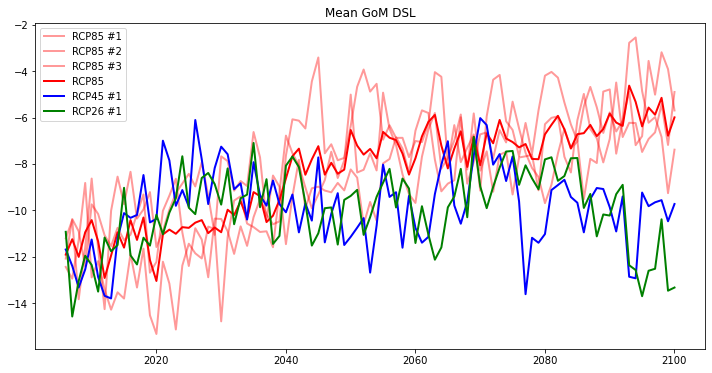

In [28]:
plt.figure(figsize=(12,6))
plt.plot(GoM_ssh_rcp85_1.time, GoM_ssh_rcp85_1, label='RCP85 #1', color='red', alpha=0.4, lw=2)
plt.plot(GoM_ssh_rcp85_2.time, GoM_ssh_rcp85_2, label='RCP85 #2', color='red', alpha=0.4, lw=2)
plt.plot(GoM_ssh_rcp85_3.time, GoM_ssh_rcp85_3, label='RCP85 #3', color='red', alpha=0.4, lw=2)
plt.plot(GoM_ssh_rcp85.time, GoM_ssh_rcp85, label='RCP85', color='red', lw=2)
plt.plot(GoM_ssh_rcp45_1.time, GoM_ssh_rcp45_1, label='RCP45 #1', color='blue', lw=2)
plt.plot(GoM_ssh_rcp26_1.time, GoM_ssh_rcp26_1, label='RCP26 #1', color='green', lw=2)
plt.legend()
plt.title('Mean GoM DSL')